# HR net

In [1]:

from PIL import Image
import torch
from tensorboard.summary.v1 import image
from torch import Tensor, nn
from torchvision import io
import numpy as np
from torchvision.transforms import functional
import os
import segmentation_models_pytorch as smp

## 一， utils

In [2]:


def keep_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path)
    max_size=max(img.size)
    mask = Image.new('RGB', (max_size, max_size), (0, 0, 0))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def keep_mask_image_size(path: str, size=(256, 256)) -> Image.Image:
    img = Image.open(path).convert("L")
    max_size=max(img.size)
    mask = Image.new('L', (max_size, max_size), 0)
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

def pad_16(image: Tensor) -> Tensor:
    width,height= functional.get_image_size(image)
    pad_height = (16 - height % 16) % 16
    pad_width = (16 - width % 16) % 16
    # 表示在左、右,上、下、四个方向 mode：指定填充模式，可以是 “constant”、“reflect” 或 “replicate”；
    pad_image = nn.functional.pad(image, (0, pad_width , 0, pad_height), mode='reflect')
    return pad_image

def pad_32(image: Tensor) -> Tensor:
    width,height= functional.get_image_size(image)
    pad_height = (32 - height % 32) % 32
    pad_width = (32 - width % 32) % 32
    # 表示在左、右,上、下、四个方向 mode：指定填充模式，可以是 “constant”、“reflect” 或 “replicate”；
    pad_image = nn.functional.pad(image, (0, pad_width , 0, pad_height), mode='reflect')
    return pad_image    

def show_image_memory_size(path: str):
    img = io.read_image(path)
    print(f"img shape:{img.shape}")
    print(f"data type:{img.dtype}")

    total_bytes = img.shape[0] * img.shape[1] * img.shape[2] * img.dtype.itemsize
    print(f"total bytes:{total_bytes},MB:{total_bytes/(1024*1024)}")



## 二， 定义模型

In [3]:
import torch
import torch._utils
import torch.nn as nn
import torch.nn.functional as F
from torch.hub  import load_state_dict_from_url

BN_MOMENTUM = 0.1


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                                  momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self.num_inchannels = num_inchannels
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=True)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels, stride=1):
        downsample = None
        if stride != 1 or self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index], num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_channels[branch_index] * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index], num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index], num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for branch_index in range(num_branches):
            branches.append(self._make_one_branch(branch_index, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        fuse_layers = []
        for i in range(self.num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(self.num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(self.num_inchannels[j], self.num_inchannels[i], 1, 1, 0, bias=False),
                        nn.BatchNorm2d(self.num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i - j):
                        if k == i - j - 1:
                            conv3x3s.append(
                                nn.Sequential(
                                    nn.Conv2d(self.num_inchannels[j], self.num_inchannels[i], 3, 2, 1, bias=False),
                                    nn.BatchNorm2d(self.num_inchannels[i], momentum=BN_MOMENTUM)
                                )
                            )
                        else:
                            conv3x3s.append(
                                nn.Sequential(
                                    nn.Conv2d(self.num_inchannels[j], self.num_inchannels[j], 3, 2, 1, bias=False),
                                    nn.BatchNorm2d(self.num_inchannels[j], momentum=BN_MOMENTUM),
                                    nn.ReLU(inplace=True)
                                )
                            )
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = 0
            # y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(0, self.num_branches):
                if j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=True
                    )
                elif i == j:
                    y = y + x[j]
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


class HighResolutionNet_Classification(nn.Module):
    def __init__(self, num_classes, backbone):
        super(HighResolutionNet_Classification, self).__init__()
        num_filters = {
            'hrnetv2_w18': [18, 36, 72, 144],
            'hrnetv2_w32': [32, 64, 128, 256],
            'hrnetv2_w48': [48, 96, 192, 384],
        }[backbone]
        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(Bottleneck, 64, 64, 4)

        pre_stage_channels = [Bottleneck.expansion * 64]
        num_channels = [num_filters[0], num_filters[1]]
        self.transition1 = self._make_transition_layer(pre_stage_channels, num_channels)
        self.stage2, pre_stage_channels = self._make_stage(1, 2, BasicBlock, [4, 4], num_channels, num_channels)

        num_channels = [num_filters[0], num_filters[1], num_filters[2]]
        self.transition2 = self._make_transition_layer(pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(4, 3, BasicBlock, [4, 4, 4], num_channels, num_channels)

        num_channels = [num_filters[0], num_filters[1], num_filters[2], num_filters[3]]
        self.transition3 = self._make_transition_layer(pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(3, 4, BasicBlock, [4, 4, 4, 4], num_channels, num_channels)

        self.pre_stage_channels = pre_stage_channels

        self.incre_modules, self.downsamp_modules, self.final_layer = self._make_head(Bottleneck, pre_stage_channels)

        self.classifier = nn.Linear(2048, num_classes)

    def _make_layer(self, block, inplanes, planes, num_blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, num_blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_transition_layer(self, num_inchannels, num_channels):
        num_branches_pre = len(num_inchannels)
        num_branches_cur = len(num_channels)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels[i] != num_inchannels[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[i], num_channels[i], 3, 1, 1, bias=False),
                        nn.BatchNorm2d(num_channels[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)
                    ))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = [
                    nn.Sequential(
                        nn.Conv2d(num_inchannels[-1], num_channels[i], 3, 2, 1, bias=False),
                        nn.BatchNorm2d(num_channels[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)
                    )
                ]
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_stage(self, num_modules, num_branches, block, num_blocks, num_inchannels, num_channels,
                    multi_scale_output=True):
        modules = []
        for i in range(num_modules):
            modules.append(
                HighResolutionModule(num_branches, block, num_blocks, num_inchannels, num_channels, multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def _make_head(self, block, pre_stage_channels):
        head_channels = [32, 64, 128, 256]

        incre_modules = []
        for i, channels in enumerate(pre_stage_channels):
            incre_module = self._make_layer(block, channels, head_channels[i], 1, stride=1)
            incre_modules.append(incre_module)
        incre_modules = nn.ModuleList(incre_modules)

        downsamp_modules = []
        for i in range(len(pre_stage_channels) - 1):
            in_channels = head_channels[i] * block.expansion
            out_channels = head_channels[i + 1] * block.expansion

            downsamp_module = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(out_channels, momentum=BN_MOMENTUM),
                nn.ReLU(inplace=True)
            )

            downsamp_modules.append(downsamp_module)
        downsamp_modules = nn.ModuleList(downsamp_modules)

        final_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=head_channels[3] * block.expansion,
                out_channels=2048,
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm2d(2048, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True)
        )

        return incre_modules, downsamp_modules, final_layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(2):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(3):
            if self.transition2[i] is not None:
                if i < 2:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(4):
            if self.transition3[i] is not None:
                if i < 3:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage4(x_list)

        y = self.incre_modules[0](y_list[0])
        for i in range(len(self.downsamp_modules)):
            y = self.incre_modules[i + 1](y_list[i + 1]) + \
                self.downsamp_modules[i](y)

        y = self.final_layer(y)

        if torch._C._get_tracing_state():
            y = y.flatten(start_dim=2).mean(dim=2)
        else:
            y = F.avg_pool2d(y, kernel_size=y.size()
            [2:]).view(y.size(0), -1)

        y = self.classifier(y)

        return y


def hrnet_classification(pretrained=False, backbone='hrnetv2_w48'):
    model = HighResolutionNet_Classification(num_classes=1000, backbone=backbone)
    if pretrained:
        model_urls = {
            'hrnetv2_w18': "https://github.com/bubbliiiing/hrnet-pytorch/releases/download/v1.0/hrnetv2_w18_imagenet_pretrained.pth",
            'hrnetv2_w32': "https://github.com/bubbliiiing/hrnet-pytorch/releases/download/v1.0/hrnetv2_w32_imagenet_pretrained.pth",
            'hrnetv2_w48': "https://github.com/bubbliiiing/hrnet-pytorch/releases/download/v1.0/hrnetv2_w48_imagenet_pretrained.pth",
        }
        state_dict = load_state_dict_from_url(model_urls[backbone], model_dir="./model_data")
        model.load_state_dict(state_dict)

    return model

In [4]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F




class HRnet_Backbone(nn.Module):
    def __init__(self, backbone='hrnetv2_w18', pretrained=False):
        super(HRnet_Backbone, self).__init__()
        self.model = hrnet_classification(backbone=backbone, pretrained=pretrained)
        del self.model.incre_modules
        del self.model.downsamp_modules
        del self.model.final_layer
        del self.model.classifier

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.conv2(x)
        x = self.model.bn2(x)
        x = self.model.relu(x)
        x = self.model.layer1(x)

        x_list = []
        for i in range(2):
            if self.model.transition1[i] is not None:
                x_list.append(self.model.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.model.stage2(x_list)

        x_list = []
        for i in range(3):
            if self.model.transition2[i] is not None:
                if i < 2:
                    x_list.append(self.model.transition2[i](y_list[i]))
                else:
                    x_list.append(self.model.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.model.stage3(x_list)

        x_list = []
        for i in range(4):
            if self.model.transition3[i] is not None:
                if i < 3:
                    x_list.append(self.model.transition3[i](y_list[i]))
                else:
                    x_list.append(self.model.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.model.stage4(x_list)

        return y_list


class HRnet(nn.Module):
    def __init__(self, num_classes=21, backbone='hrnetv2_w18', pretrained=False):
        super(HRnet, self).__init__()
        self.backbone = HRnet_Backbone(backbone=backbone, pretrained=pretrained)

        last_inp_channels = np.int32(np.sum(self.backbone.model.pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(in_channels=last_inp_channels, out_channels=last_inp_channels, kernel_size=1, stride=1,
                      padding=0),
            nn.BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=last_inp_channels, out_channels=num_classes, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, inputs):
        H, W = inputs.size(2), inputs.size(3)
        x = self.backbone(inputs)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=True)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=True)

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)
        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        return torch.sigmoid(x)

if __name__ == '__main__':
    model = HRnet(num_classes=1,pretrained=True)
    input_data = torch.randn(size=(1, 3, 512, 512))
    output = model(input_data)
    print(output)



tensor([[[[0.7505, 0.7315, 0.7115,  ..., 0.6041, 0.5818, 0.5592],
          [0.7256, 0.7117, 0.6973,  ..., 0.6140, 0.5974, 0.5806],
          [0.6993, 0.6910, 0.6827,  ..., 0.6238, 0.6128, 0.6018],
          ...,
          [0.4747, 0.4979, 0.5211,  ..., 0.7036, 0.7262, 0.7477],
          [0.4695, 0.4945, 0.5195,  ..., 0.7035, 0.7281, 0.7514],
          [0.4644, 0.4911, 0.5179,  ..., 0.7033, 0.7299, 0.7550]]]],
       grad_fn=<SigmoidBackward0>)


## 三，dataset

In [5]:
import os
import torch
from functorch.dim import Tensor
from torch.utils.data import Dataset
from torchvision import transforms
import shutil
import random

transform = transforms.Compose([
    transforms.ToTensor()
])

# 路径，和最大 图片像素
class WaterDataset(Dataset):
    def __init__(self, path,max_size=2000_000):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []
        self.max_size=max_size

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            # 图片太大，进行等比列缩放-内存不足

            width, height = image.size
            pixel_num = width * height
            if pixel_num > self.max_size:
                scale_factor = self.max_size / pixel_num
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                # 缩放图像,建议双线性插值
                image = image.resize((new_width, new_height), resample=Image.LANCZOS)
                mask_image = mask_image.resize((new_width, new_height), resample=Image.LANCZOS)

            image = transform(image)
            mask_image = transform(mask_image)

            return pad_16(image), pad_16(mask_image)
        except Exception as e:
            print(f"数据错误: {image_path}", e)
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


transform512 = transforms.Compose([
    transforms.Resize(512),  # 保持长宽比，调整最短边为512像素
    transforms.CenterCrop(512),  # 从中心裁剪512x512的图片
    transforms.ToTensor()  # 转换成Tensor，方便后续处理
])


class WaterDataset512(Dataset):
    def __init__(self, path):
        super().__init__()
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            image = transform512(image)
            mask_image = transform512(mask_image)

            return image, mask_image
        except  Exception as e:
            print(f"数据错误: {image_path},{e}")
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


# 图像数据增强
class ExtendTransform:
    # 图像数据进行增强，
    # ["original", "h_flip", "v_flip", "rotate_90", "rotate_180", "rotate_270"]
    def __init__(self, transform_type_list=["original", "h_flip"]):
        self.transform_type_list = transform_type_list

    def __call__(self, image, mask):

        image, mask = functional.to_tensor(image), functional.to_tensor(mask)
        type = random.choice(self.transform_type_list)

        if type == "original":
            return image, mask
        if type == "h_flip":
            return functional.hflip(image), functional.hflip(mask)
        if type == "v_flip":
            return functional.vflip(image), functional.vflip(mask)
        if type == "rotate_90":
            return functional.rotate(image, 90, expand=True), functional.rotate(mask, 90, expand=True)
        if type == "rotate_180":
            return functional.rotate(image, 180), functional.rotate(mask, 180)
        if type == "rotate_270":
            return functional.rotate(image, 270, expand=True), functional.rotate(mask, 270, expand=True)


extend_transforms = ExtendTransform()


class ExtendWaterDataset(Dataset):
    def __init__(self, path, max_size=2000_000, extend_flag=True):
        super().__init__()
        # 数据是否进行增强
        self.extend_flag = extend_flag
        self.path = path
        self.mask_path_list = []
        self.image_path_list = []
        self.max_size = max_size

        self.mask_path = os.path.join(path, 'Annotations')
        self.image_path = os.path.join(path, 'JPEGImages')

        for dir_name, _, file_names in os.walk(self.mask_path):
            for file_name in file_names:
                mask_path = os.path.join(dir_name, file_name)
                image_path_jpg = mask_path.replace("Annotations", "JPEGImages").replace(".png", ".jpg")
                image_path_png = mask_path.replace("Annotations", "JPEGImages")

                if os.path.exists(image_path_jpg):
                    self.image_path_list.append(image_path_jpg)
                    self.mask_path_list.append(mask_path)
                elif os.path.exists(image_path_png):
                    self.image_path_list.append(image_path_png)
                    self.mask_path_list.append(mask_path)
                else:
                    print(f"找不到图片： {image_path_png}  ｛image_path_jpg｝")

    def __len__(self):
        return len(self.mask_path_list)

    def __getitem__(self, index) -> tuple[Tensor, Tensor]:
        image_path = self.image_path_list[index]
        image_mask_path = self.mask_path_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
            mask_image = Image.open(image_mask_path).convert("L")

            # 图片太大，进行等比列缩放-内存不足
            width, height = image.size
            pixel_num = width * height
            if pixel_num > self.max_size:
                scale_factor = self.max_size / pixel_num
                new_width = int(width * scale_factor)
                new_height = int(height * scale_factor)
                # 缩放图像,建议双线性插值
                image = image.resize((new_width, new_height), resample=Image.LANCZOS)
                mask_image = mask_image.resize((new_width, new_height), resample=Image.LANCZOS)

            # 是否增强
            if self.extend_flag:
                image, mask_image = extend_transforms(image, mask_image)
            else:
                image = transform(image)
                mask_image = transform(mask_image)

            return pad_16(image), pad_16(mask_image)
        except Exception as e:
            print(f"数据错误: {image_path}", e)
            return torch.randn(0, 1, 1, 1), torch.randn(0, 1, 1, 1)


## 四，训练

找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00.json  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label.png  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label_viz.png  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/info.yaml  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/label_names.txt  ｛image_path_jpg｝
找不到图片： ../imags/water_v2/water_v2/JPEGImages/stream2/12_00_json/img.png  ｛image_path_jpg｝


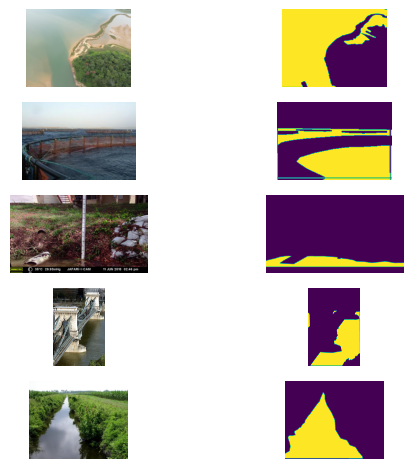

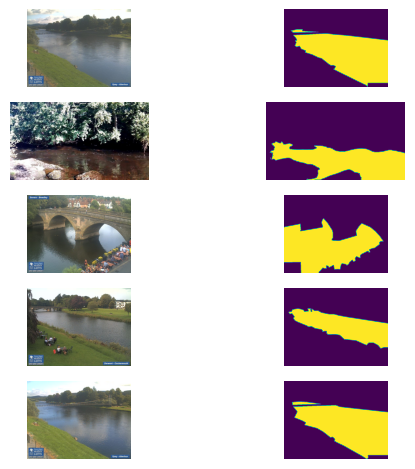

[6/100]:  37%|███▋      | 2373/6414 [04:53<08:20,  8.08it/s, loss=292, train_miou=0.746]


KeyboardInterrupt: 

In [7]:
import torch
from torch.optim import *
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional, transforms
from torchvision.transforms.v2 import ToPILImage

import logging
from torchmetrics.segmentation import MeanIoU

from copy import deepcopy
from  tqdm import  trange,tqdm
from colorama import Fore
# 训练停止条件，连续 多少次没有增长
class TrainStop:
    def __init__(self, count=3):
        self.count = count
        self.score_list = [0.0]
        self.best = 0.0
        self.trigger_count = 0

    def __call__(self, score: float) -> bool:
        self.score_list.append(score)
        total = sum(self.score_list[-self.count:])
        # 最佳分数： 最后几次平均分
        mean = total / self.count
        if mean > self.best:
            self.best = mean

        # 分数没有超过之前，已经 count 次，就停止
        if self.best > score:
            self.trigger_count += 1
            if self.trigger_count > self.count + 1:
                return True

        return False


# 日志
def config_logger(name="train"):
    # 设置日志的基本配置
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    logger = logging.getLogger("train")
    logger.setLevel(logging.DEBUG)

    # 创建一个handler，用于写入日志文件
    file_handler = logging.FileHandler('app.log')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # # 再创建一个handler，用于输出到控制台
    # stream_handler = logging.StreamHandler()
    # stream_handler.setFormatter(formatter)
    # logger.addHandler(stream_handler)

    return logger


# 合并datasets
def merge_datasets(dataset_list):
    image_path_list = []
    mask_path_list = []
    for dataset in dataset_list:
        image_path_list = image_path_list + dataset.image_path_list
        mask_path_list = mask_path_list + dataset.mask_path_list

    new_dataset = WaterDataset(dataset_list[0].path,max_size=2000_000)
    new_dataset.image_path_list = image_path_list
    new_dataset.mask_path_list = mask_path_list

    return new_dataset


def show_images(dataloader,num=3):
    to_pil_image = ToPILImage()
    plt.figure()
    for i in range(1,num*2,2):
       imgs,masks=  dataloader.dataset[i]
       plt.subplot(num, 2,i)
       plt.imshow(to_pil_image(imgs))
       plt.axis('off')

       plt.subplot(num, 2, i+1)
       plt.imshow(to_pil_image(masks))
       plt.axis('off')

    plt.tight_layout()  # 调整子图间距
    plt.show()




logger = config_logger()
train_stop = TrainStop(count=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


dataset1 = WaterDataset("../imags/water-3")
dataset2 = WaterDataset("../imags/water-v2-date-title")
dataset3 = WaterDataset("../imags/water_v1/water_v1")
dataset4 = WaterDataset("../imags/water_v2/water_v2")


dataset = merge_datasets([dataset1, dataset2,dataset3,dataset4])

# 每次都生成一样
generator = torch.Generator().manual_seed(666)
total_length = len(dataset)
var_length = int(total_length * 0.1)
train_dataset, val_dataset = random_split(dataset, [total_length - var_length, var_length],generator=generator)

#深复制验证集-验证-数据不进行增强，保持一致
val_dataset = deepcopy(val_dataset)
val_dataset.dataset.extend_flag=False

train_dataloader = DataLoader(dataset=train_dataset, batch_size=1)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1)

logger.info(f"训练数据: {len(train_dataloader)}  测试训练数据: {len(val_dataloader)} ")

show_images(val_dataloader,5)
show_images(train_dataloader,5)


# model = HRnet(num_classes=1,pretrained=True,backbone='hrnetv2_w48').to(device)
model = HRnet(num_classes=1,pretrained=False,backbone='hrnetv2_w18').to(device)

loss = nn.BCELoss().to(device)
optimizer = Adam(model.parameters(), 0.001)
mean_iou = MeanIoU(num_classes=2).to(device)

for epoch in range(100):
    # 训练
    model.train()
    total_loss = 0
    train_mean_iou=0
    mean_iou.reset()
    train_bar=tqdm(train_dataloader,total=len(train_dataloader),leave=True, postfix=Fore.GREEN)
    train_bar.set_description(f"[{epoch}/100]")
    for step, (images, mask_images) in enumerate(train_bar):
        images, mask_images = images.to(device), mask_images.to(device)
        height, width = functional.get_image_size(images)

        if images.shape[1] > 3:
            continue
        if mask_images.shape[1] > 1:
            continue
        if images.shape[2] == 1:
            continue

        model_result = model(images)

        loss_result = loss(model_result, mask_images)

        optimizer.zero_grad()
        loss_result.backward()
        optimizer.step()

        # 指标
        total_loss += loss_result.item()
        mean_iou.update((model_result > 0.5).long(), mask_images.long())

        train_mean_iou = mean_iou.compute().item() 
        train_bar.set_postfix(train_miou=train_mean_iou, loss=total_loss)

 


    # 验证
    model.eval()
    mean_iou.reset()
    var_mean_iou = 0
    var_bar = tqdm(val_dataloader, total=len(val_dataloader), leave=True, postfix=Fore.RED)
    var_bar.set_description(f"[{epoch}/100]")
    with torch.no_grad():
        for step, (images, targets) in enumerate(var_bar) :
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            # 阈值化并转换为整数类型
            outputs = (outputs > 0.5).long()
            mean_iou.update((outputs > 0.5).long(), targets.long())
            var_mean_iou = mean_iou.compute().item() 
            var_bar.set_postfix(var_miou=var_mean_iou)
 
    torch.save(model, f"N-hrnet-w18-{epoch}.pth")   
    logger.info(f"第epoch:{epoch} var-miou:{var_mean_iou} train-miou:{train_mean_iou} total_loss:{total_loss} pth: unet-plus{epoch}.pth")
 
    # 是否停止
    is_stop = train_stop(var_mean_iou)
    if is_stop:
        logger.info(f"停止训练: epoch:{epoch} 最佳iou {train_stop.best} , score_list:{train_stop.score_list}")
        print(f"停止训练: epoch:{epoch} 最佳iou {train_stop.best} , score_list:{train_stop.score_list}")
        break


In [ ]:
! pip  install --upgrade torch torchvision torchaudio

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 9.0 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 10.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 9.4 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 10.0 MB/s eta 0:00:0000:0100:01
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torc